<a href="https://colab.research.google.com/github/tigrulya-exe/Neural-Network-Labs/blob/master/NewInceptionV4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Concatenate, Dropout, Dense, Flatten, Activation
from keras.layers.convolutional import MaxPooling2D, Conv2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import cv2

from keras import backend as K
K.common.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train.shape

(50000, 32, 32, 3)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, CIFAR_10_CLASSES_COUNT)
y_test = keras.utils.to_categorical(y_test, CIFAR_10_CLASSES_COUNT)

In [0]:
CHANNEL_AXIS = -1
VALID_BORDER_MODE = 'valid'
SAME_BORDER_MODE = 'same'

def get_conv_block(x, nb_filter, kernel_height, kernel_width, border_mode='same', subsample=(1, 1)):
    return Conv2D(nb_filter, (kernel_height, kernel_width), strides=subsample, padding=border_mode, activation='relu',  kernel_initializer = 'he_uniform')(x)

def get_inception_stem(input):
    x = get_conv_block(input, 32, 3, 3, subsample=(2, 2), border_mode=VALID_BORDER_MODE)

    x = get_conv_block(x, 32, 3, 3, border_mode=VALID_BORDER_MODE)
    x = get_conv_block(x, 64, 3, 3)

    x1 = MaxPooling2D((3, 3), strides=(2, 2), padding=SAME_BORDER_MODE)(x)
    
    x2 = get_conv_block(x, 96, 3, 3, subsample=(2, 2), border_mode=SAME_BORDER_MODE)

    x = Concatenate(axis=CHANNEL_AXIS)([x1, x2])

    x1 = get_conv_block(x, 64, 1, 1)
    x1 = get_conv_block(x1, 96, 3, 3, border_mode=VALID_BORDER_MODE)

    x2 = get_conv_block(x, 64, 1, 1)
    x2 = get_conv_block(x2, 64, 1, 7)
    x2 = get_conv_block(x2, 64, 7, 1)
    x2 = get_conv_block(x2, 96, 3, 3, border_mode=VALID_BORDER_MODE)

    x = Concatenate(axis=CHANNEL_AXIS)([x1, x2])

    x1 = get_conv_block(x, 192, 3, 3, subsample=(2, 2), border_mode=VALID_BORDER_MODE)
    
    x2 = MaxPooling2D((3, 3), strides=(2, 2), padding=VALID_BORDER_MODE)(x)

    return Concatenate(axis=CHANNEL_AXIS)([x1, x2])



def get_inception_A(input):
    a1 = get_conv_block(input, 96, 1, 1)

    a2 = get_conv_block(input, 64, 1, 1)
    a2 = get_conv_block(a2, 96, 3, 3)

    a3 = get_conv_block(input, 64, 1, 1)
    a3 = get_conv_block(a3, 96, 3, 3)
    a3 = get_conv_block(a3, 96, 3, 3)

    a4 = AveragePooling2D((2, 2), strides=(1, 1), padding=SAME_BORDER_MODE)(input)
    a4 = get_conv_block(a4, 96, 1, 1)

    return Concatenate(axis=CHANNEL_AXIS)([a1, a2, a3, a4])


def get_inception_B(input):
    b1 = get_conv_block(input, 384, 1, 1)

    b2 = get_conv_block(input, 192, 1, 1)
    b2 = get_conv_block(b2, 224, 1, 7)
    b2 = get_conv_block(b2, 256, 7, 1)

    b3 = get_conv_block(input, 192, 1, 1)
    b3 = get_conv_block(b3, 192, 7, 1)
    b3 = get_conv_block(b3, 224, 1, 7)
    b3 = get_conv_block(b3, 224, 7, 1)
    b3 = get_conv_block(b3, 256, 1, 7)

    b4 = AveragePooling2D((2, 2), strides=(1, 1), padding=SAME_BORDER_MODE)(input)

    b4 = get_conv_block(b4, 128, 1, 1)

    return Concatenate(axis=CHANNEL_AXIS)([b1, b2, b3, b4])


def get_inception_C(input):
    c1 = get_conv_block(input, 256, 1, 1)

    c2 = get_conv_block(input, 384, 1, 1)
    c2_1 = get_conv_block(c2, 256, 1, 3)
    c2_2 = get_conv_block(c2, 256, 3, 1)

    c3 = get_conv_block(input, 384, 1, 1)
    c3 = get_conv_block(c3, 448, 3, 1)
    c3 = get_conv_block(c3, 512, 1, 3)
    c3_1 = get_conv_block(c3, 256, 1, 3)
    c3_2 = get_conv_block(c3, 256, 3, 1)

    c4 = AveragePooling2D((3, 3), strides=(1, 1), padding=SAME_BORDER_MODE)(input)
    c4 = get_conv_block(c4, 256, 1, 1)

    return Concatenate(axis=CHANNEL_AXIS)([c1, c2_1, c2_2, c3_1, c3_2, c4])


def get_reduction_A(input):
    r1 = get_conv_block(input, 384, 3, 3, subsample=(2, 2))
    r2 = get_conv_block(input, 192, 1, 1)
    r2 = get_conv_block(r2, 224, 3, 3)
    r2 = get_conv_block(r2, 256, 3, 3, subsample=(2, 2))
    r3 = MaxPooling2D((3, 3), strides=(2, 2), padding=SAME_BORDER_MODE)(input)

    return Concatenate(axis=CHANNEL_AXIS)([r1, r2, r3])    


def get_reduction_B(input):
    r1 = get_conv_block(input, 192, 1, 1)
    r1 = get_conv_block(r1, 192, 3, 3, subsample=(2, 2))

    r2 = get_conv_block(input, 256, 1, 1)
    r2 = get_conv_block(r2, 256, 1, 7)
    r2 = get_conv_block(r2, 320, 7, 1)
    r2 = get_conv_block(r2, 320, 3, 3, subsample=(2, 2))

    r3 = MaxPooling2D((3, 3), strides=(2, 2), padding=SAME_BORDER_MODE)(input)

    return Concatenate(axis=CHANNEL_AXIS)([r1, r2, r3])    

In [0]:
def create_inception_v4(nb_classes=1001):
    
    init = Input(shape = (32, 32, 3))

    x = get_inception_stem(init)

    for i in range(4):
        x = get_inception_A(x)

    x = get_reduction_A(x)

    for i in range(7):
        x = get_inception_B(x)

    x = get_reduction_B(x)

    for i in range(3):
        x = get_inception_C(x)
        
    x = AveragePooling2D(padding = 'same')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)

    out = Dense(units=nb_classes, activation='softmax',kernel_initializer = 'he_uniform')(x)
    return Model(init, out, name='Inception V4')

In [0]:
CIFAR_10_CLASSES_COUNT = 10
inception = create_inception_v4(CIFAR_10_CLASSES_COUNT)

In [0]:
inception.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr = 0.01, momentum = 0.9),
              metrics=['accuracy'])

In [112]:
inception.summary()

Model: "Inception V4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1722 (Conv2D)            (None, 15, 15, 32)   896         input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_1723 (Conv2D)            (None, 13, 13, 32)   9248        conv2d_1722[0][0]                
__________________________________________________________________________________________________
conv2d_1724 (Conv2D)            (None, 13, 13, 64)   18496       conv2d_1723[0][0]                
_______________________________________________________________________________________

In [108]:
inception.fit(x_train, y_train,
              batch_size=100,
              epochs=60,
              validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/60
50000/50000 [==============================] - 45s 900us/step - loss: 2.0503 - accuracy: 0.2015 - val_loss: 1.8264 - val_accuracy: 0.2990
Epoch 2/60
50000/50000 [==============================] - 43s 860us/step - loss: 1.7159 - accuracy: 0.3337 - val_loss: 1.6246 - val_accuracy: 0.3856
Epoch 3/60
50000/50000 [==============================] - 43s 859us/step - loss: 1.5538 - accuracy: 0.4113 - val_loss: 1.4402 - val_accuracy: 0.4638
Epoch 4/60
50000/50000 [==============================] - 43s 859us/step - loss: 1.3844 - accuracy: 0.4879 - val_loss: 1.3247 - val_accuracy: 0.5170
Epoch 5/60
50000/50000 [==============================] - 43s 860us/step - loss: 1.2372 - accuracy: 0.5519 - val_loss: 1.2637 - val_accuracy: 0.5390
Epoch 6/60
50000/50000 [==============================] - 43s 861us/step - loss: 1.1241 - accuracy: 0.6011 - val_loss: 1.2173 - val_accuracy: 0.5664
Epoch 7/60
50000/50000 [==============================] 

In [0]:
predictions = inception.predict(x_test);
class_label = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'];

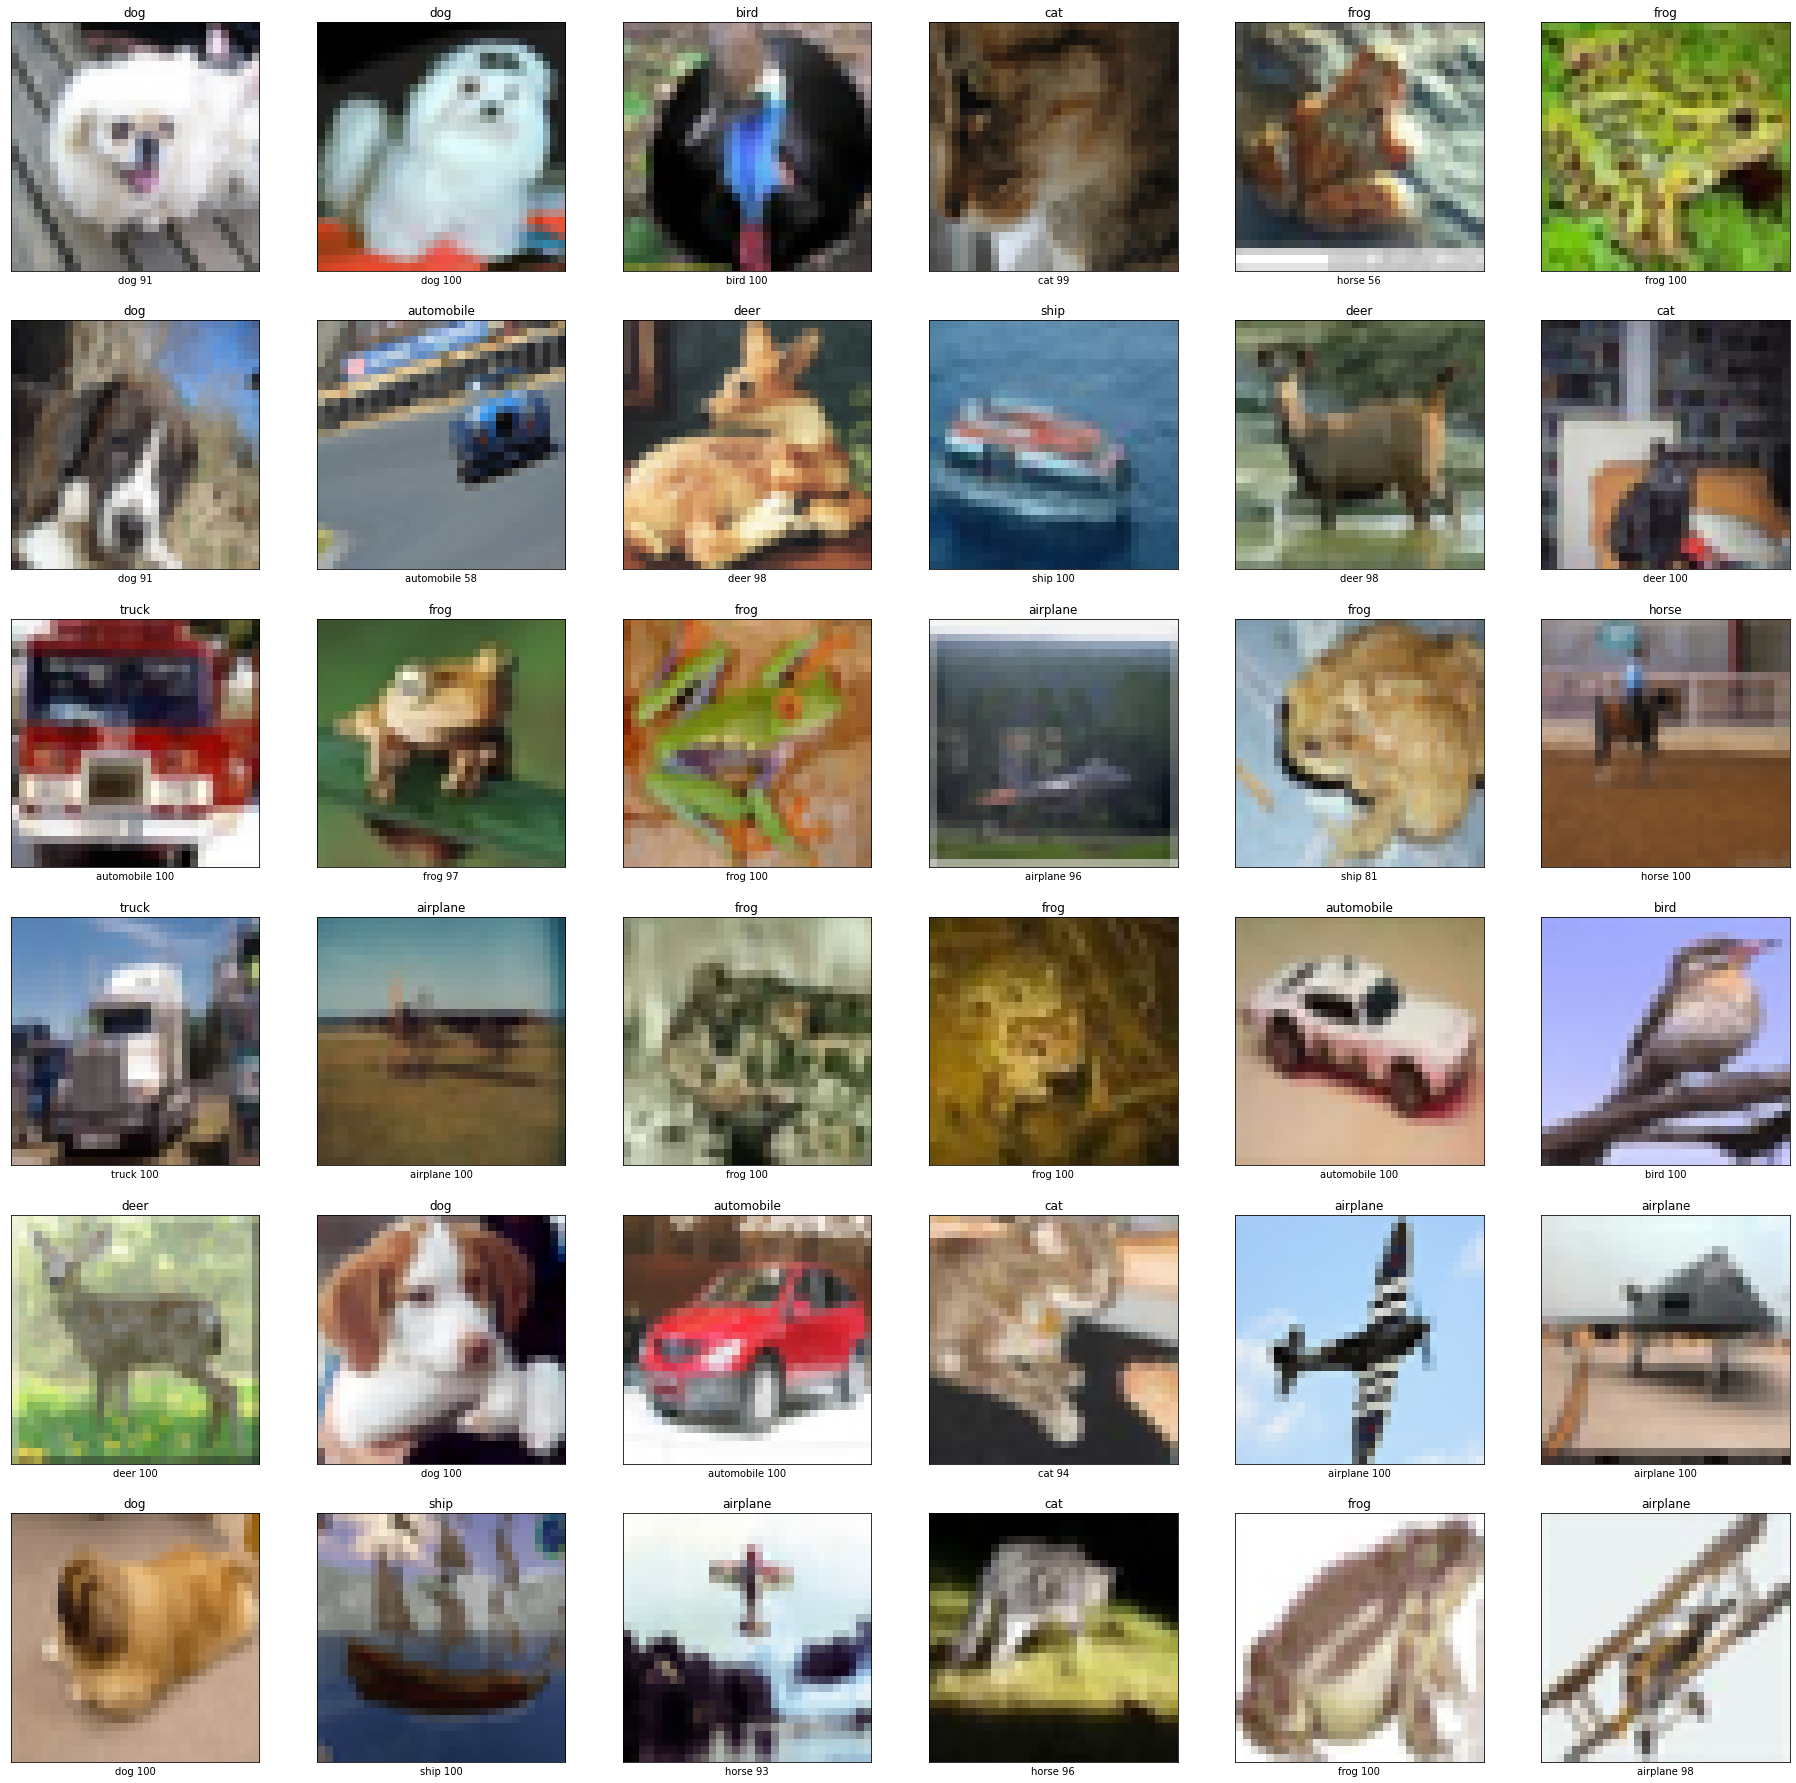

In [130]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(32,32));

for i in range(36):
    plt.subplot(6,6,i+1);
    plt.xticks([]);
    plt.yticks([]);
    rand_i = random.randint(0, 10000)
    plt.imshow(x_test[rand_i]);
    plt.xlabel(f'{class_label[np.argmax(predictions[rand_i])]} {100*np.max(predictions[rand_i]):2.0f}')
    plt.title(class_label[np.argmax(y_test[rand_i])]);
plt.show();

In [0]:
!pip install pyyaml h5py 
import os
inception.save_weights('./weights_new')
!mkdir -p saved_model
inception.save('saved_model/inception_new')